In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split

from src.files_io import load_raw_mailout_datasets
from src.preprocessing import preprocess_data

In [ ]:
"""
Load & Preprocess Data
- to prevent naming irritations, we name the provided test dataset "competition", because it is used to compete with the model results
"""

In [2]:
train_raw, competition_raw = load_raw_mailout_datasets()

Mailout datasets loaded.


In [3]:
train_response = train_raw["response"]

In [4]:
train_preprocessed, competition_preprocessed = preprocess_data(train_raw, competition_raw, ("train", "competition_test"))

Metadata loaded.
Metadata rectified.
Feature config loaded.

Start cleaning train dataset...
Removed 3 irrelevant features.
Converted 324 unknown values from the meta information to null in the dataset.
Converted 8 invalid values to null in the dataset.
Removed 7962 records with over 33.0% missing feature values.
Removed 6 features with over 20.0% missing values:
alter_kind3, alter_kind4, extsel992, geburtsjahr, kba05_baumax, kk_kundentyp
Replaced missing values in 136 features.
Extracted decade and cultural orientation as separate features.
Extracted wealth and life phase as separate features.
Removed 51 redundant features.
Removed 24 uncertain features.

Start cleaning competition_test dataset...
Removed 3 irrelevant features.
Converted 324 unknown values from the meta information to null in the dataset.
Converted 8 invalid values to null in the dataset.
Removed 7841 records with over 33.0% missing feature values.
Removed 6 features with over 20.0% missing values:
alter_kind3, alter_

In [5]:
train_preprocessed = train_preprocessed.join(train_response, how="left")

assert train_preprocessed["response"].isnull().sum() == 0

In [6]:
"""
# Class Imbalance
- high imbalance (just 1% are responders)
"""

'\n# Class Imbalance\n- high imbalance (just 1% are responders)\n'

In [7]:
train_preprocessed["response"].value_counts(normalize=True)

response
0    0.987571
1    0.012429
Name: proportion, dtype: float64

In [8]:
"""
# Split Dataset
- stratified sampling due to class imbalance
- to avoid data leakage and ensure unbiased evaluation, we use a validation set for early stopping and hyperparameter tuning and a separate test set (data that the model has never seen before) for the final evaluation:
  - training set: for model training
  - validation set: for early stopping and hyperparameter tuning
  - test set: for final evaluation
"""

'\n# Split Dataset\n- stratified sampling due to class imbalance\n- to avoid data leakage and ensure unbiased evaluation, we use a validation set for early stopping and hyperparameter tuning and a separate test set (data that the model has never seen before) for the final evaluation:\n  - training set: for model training\n  - validation set: for early stopping and hyperparameter tuning\n  - test set: for final evaluation\n'

In [9]:
train, validation_test = train_test_split(train_preprocessed, test_size=0.3, random_state=42, stratify=train_preprocessed["response"])

validation, test = train_test_split(validation_test, test_size=0.5, random_state=42, stratify=validation_test["response"])

del validation_test

In [10]:
"""
# Train XGBoost Classification Model
- binary classification model (person will respond: yes or no)
- gradient boosting decision trees are highly effective and very successful in solving various ml problems
- XGBoost can appropriately handle class imbalance with the `scale_pos_weigth` parameter
- evaluation metric: precision recall auc
  - focuses only on the performance for the positive class (responders), ignoring the abundance of negatives, making it much more informative than ROC AUC when dealing with highly imbalanced datasets
  - summarizes the model"s performance across all possible thresholds (unlike the f1 score)
  - highlights how well the model identifies true positives without being overwhelmed by the majority class
  - mail costs are not that much, so our focus is not to miss a potential customer
"""

'\n# Train XGBoost Classification Model\n- binary classification model (person will respond: yes or no)\n- gradient boosting decision trees are highly effective and very successful in solving various ml problems\n- XGBoost can appropriately handle class imbalance with the `scale_pos_weigth` parameter\n- evaluation metric: precision recall auc\n  - focuses only on the performance for the positive class (responders), ignoring the abundance of negatives, making it much more informative than ROC AUC when dealing with highly imbalanced datasets\n  - summarizes the model"s performance across all possible thresholds (unlike the f1 score)\n  - highlights how well the model identifies true positives without being overwhelmed by the majority class\n  - mail costs are not that much, so our focus is not to miss a potential customer\n'

In [11]:
def split_features_and_response(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    y = df["response"]
    X = df.drop(columns=["response"])
    return X, y


X_train, y_train = split_features_and_response(train)
dtrain = xgb.DMatrix(data=X_train, label=y_train)

X_validation, y_validation = split_features_and_response(validation)
dvalidation = xgb.DMatrix(data=X_validation, label=y_validation)

In [12]:
sum_negatives = len(y_train) - sum(y_train)
sum_positives = sum(y_train)
scale_pos_weight = sum_negatives / sum_positives

hyperparameters = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "scale_pos_weight": scale_pos_weight,
    "eta": 0.1,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
}

model = xgb.train(
    params=hyperparameters,
    dtrain=dtrain,
    evals=[(dtrain, "train"), (dvalidation, "validation")],
    early_stopping_rounds=20,
    num_boost_round=1000,
)

[0]	train-aucpr:0.05243	validation-aucpr:0.02831
[1]	train-aucpr:0.10830	validation-aucpr:0.02494
[2]	train-aucpr:0.12460	validation-aucpr:0.02388
[3]	train-aucpr:0.17031	validation-aucpr:0.02481
[4]	train-aucpr:0.20522	validation-aucpr:0.02750
[5]	train-aucpr:0.20039	validation-aucpr:0.02664
[6]	train-aucpr:0.20754	validation-aucpr:0.02567
[7]	train-aucpr:0.21526	validation-aucpr:0.02560
[8]	train-aucpr:0.22511	validation-aucpr:0.02446
[9]	train-aucpr:0.22082	validation-aucpr:0.02570
[10]	train-aucpr:0.26471	validation-aucpr:0.02563
[11]	train-aucpr:0.27044	validation-aucpr:0.02619
[12]	train-aucpr:0.30762	validation-aucpr:0.02771
[13]	train-aucpr:0.31792	validation-aucpr:0.02769
[14]	train-aucpr:0.32524	validation-aucpr:0.02838
[15]	train-aucpr:0.33094	validation-aucpr:0.02980
[16]	train-aucpr:0.33703	validation-aucpr:0.03054
[17]	train-aucpr:0.34362	validation-aucpr:0.03281
[18]	train-aucpr:0.34977	validation-aucpr:0.03319
[19]	train-aucpr:0.36961	validation-aucpr:0.03190
[20]	train

In [13]:
best_iteration = model.best_iteration
print(f"Best iteration: {best_iteration}")

# model.save_model("best_model.xgb")

Best iteration: 40


In [14]:
"""
# Precision Recall Curve
"""

'\n# Precision Recall Curve\n'

In [15]:
X_test, y_test = split_features_and_response(test)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
"""
- calculate precision, recall, thresholds
- average precision score (summary metric)
"""

In [30]:
y_scores = model.predict(dtest, output_margin=False)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

ap_score = average_precision_score(y_test, y_scores)

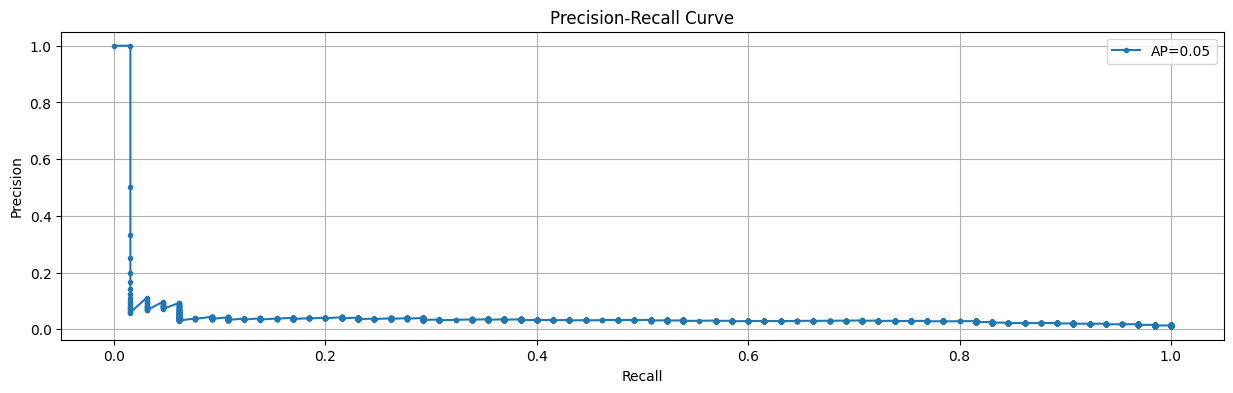

In [31]:
plt.figure(figsize=(15,4))
plt.plot(recall, precision, marker=".", label=f"AP={ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

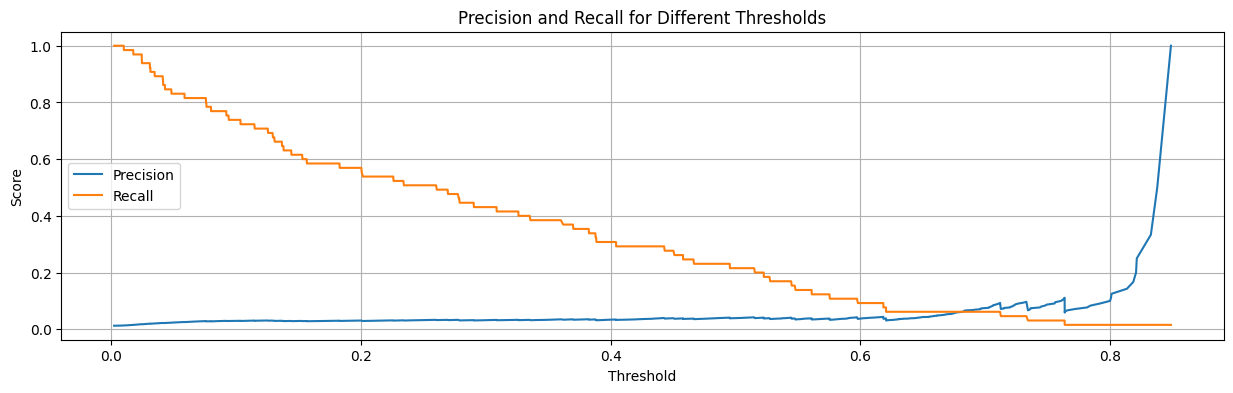

In [32]:
plt.figure(figsize=(15,4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall for Different Thresholds")
plt.legend()
plt.grid()
plt.show()